In [31]:
import pandas as pd
import numpy as np

In [32]:
val_dataset_df = pd.read_csv("./coco-2014/dataset_csv/val_dataset.csv")
val_dataset_df.head()

,file_name,file_path,height,width,image_id,caption
0,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,Two men wearing aprons working in a commercial...
1,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,Chefs preparing food in a professional metalli...
2,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,Two people standing around in a large kitchen.
3,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,A commercial kitchen with two men working to p...
4,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,two men in white shirts in a large steel kitchen


In [33]:
test_dataset_df = pd.read_csv('./coco-2014/dataset_csv/test_dataset.csv')
test_list_image_paths = np.random.choice(test_dataset_df['file_path'].values, size=20)
test_list_image_paths

array(['/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000005354.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000002039.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000000027.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000001266.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000002799.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000003884.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000004336.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000003434.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000003618.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000001116.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000002677.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000003868.jpg',
       '/home/ha

In [34]:
val_list_image_paths = np.random.choice(val_dataset_df['file_path'].values, size=20)
val_list_image_paths

array(['/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000000675.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000000415.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000004275.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000006306.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000005107.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000001993.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000000328.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000004359.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000005001.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000003084.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000004979.jpg',
       '/home/harsh/fiftyone/coco-2014/vali

# Inference and Evaluation

In [1]:
import os
import sys

import torch
from transformers import Dinov2Config, TrainingArguments, Trainer

from dataset import InferenceDataset
from image_model.image_model import load_dinov2_image_encoder
from tokenizer import load_tokenizer
from utils import (
    get_huggingface_trainer_config,
    get_showandtell_gpt2_model_config,
    read_yaml,
    make_dir,
    get_split_config,
    get_tokenizer_config,
    get_dataset_config,
    get_model_config,
    get_inference_dataset_config,
    get_image_model_config,
    get_text_model_config,
)
from showandtell_gpt2.showandtell_gpt2_model import (
    load_showandtell_gpt2,
    load_pretrained_gpt2_model,
)
from model import to_device

In [2]:
config = read_yaml("./showandtell_gpt2/configs/inference_config.yaml")

In [3]:
description, image_paths, dataset_config = get_inference_dataset_config(config)
dataset_config

{'return_dict': True, 'return_tensors': 'pt', 'image_size': [518, 518]}

In [4]:
inference_dataset = InferenceDataset(image_paths, **dataset_config)
inference_dataloader = torch.utils.data.DataLoader(inference_dataset, batch_size=1)
outs = next(iter(inference_dataloader))

In [5]:
tokenizer_name, tokenizer_path, tokenizer_config = get_tokenizer_config(config)
tokenizer = load_tokenizer(
    tokenizer_name=tokenizer_name,
    tokenizer_path=tokenizer_path,
    tokenizer_config=tokenizer_config,
)

In [6]:
# Initialize Models
model_config = get_model_config(config)

# Image encoder initialization
image_model_name, image_model_path, freeze, image_model_config = (
    get_image_model_config(model_config)
)
dinov2_config = Dinov2Config(**image_model_config)
image_encoder = load_dinov2_image_encoder(dinov2_config, freeze, image_model_path)

# Text encoder initialization
text_model_name, text_model_path, text_model_config = get_text_model_config(
    model_config
)
text_model_config.update(
    {
        "bos_token_id": tokenizer.bos_token_id,
        "eos_token_id": tokenizer.eos_token_id,
        "pad_token_id": tokenizer.pad_token_id,
        "vocab_size": len(tokenizer),
    }
)
gpt2_text_encoder = load_pretrained_gpt2_model(
    text_model_path,
    ignore_mismatched_sizes=True,
    use_safetensors=True,
    **text_model_config,
)

# Combined model initialization (Show and Tell)
(
    showandtell_gpt2_core_model_name,
    showandtell_gpt2_core_model_path,
    showandtell_gpt2_core_config,
) = get_showandtell_gpt2_model_config(model_config)
showandtell_gpt2 = to_device(load_showandtell_gpt2(
    tokenizer,
    image_encoder,
    gpt2_text_encoder,
    pretrained_model_path=showandtell_gpt2_core_model_path,
), 'cuda:0')

In [7]:
# generated_tokens[0]

In [8]:
captions = []
with torch.no_grad():
    for batch in inference_dataloader:
        pixel_values = to_device(batch['pixel_values'], 'cuda:0')
        generated_tokens = showandtell_gpt2.generate(pixel_values)
        decoded_text = tokenizer.batch_decode(
            generated_tokens, skip_special_tokens=True
        )[0]
        captions.append(decoded_text)

# Displaying Images and their captions

In [9]:
captions

[' A large plane sitting on top of a runway. ',
 ' A dog standing in front of a field. ',
 ' A man in a baseball bat in a ball. ',
 ' A man is playing with a baseball game. ',
 ' A herd of cows grazing in the grass. ',
 ' A man in progress in the baseball game and umpire. ',
 ' A dog stands in a white dog standing on a brick street. ',
 ' A man jumping in the skateboard on a skateboard. ',
 ' A person stop that is is on the side of a street. ',
 ' A woman is with a woman on the wall with a woman. ']

/tmp/ipykernel_74390/3967433444.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


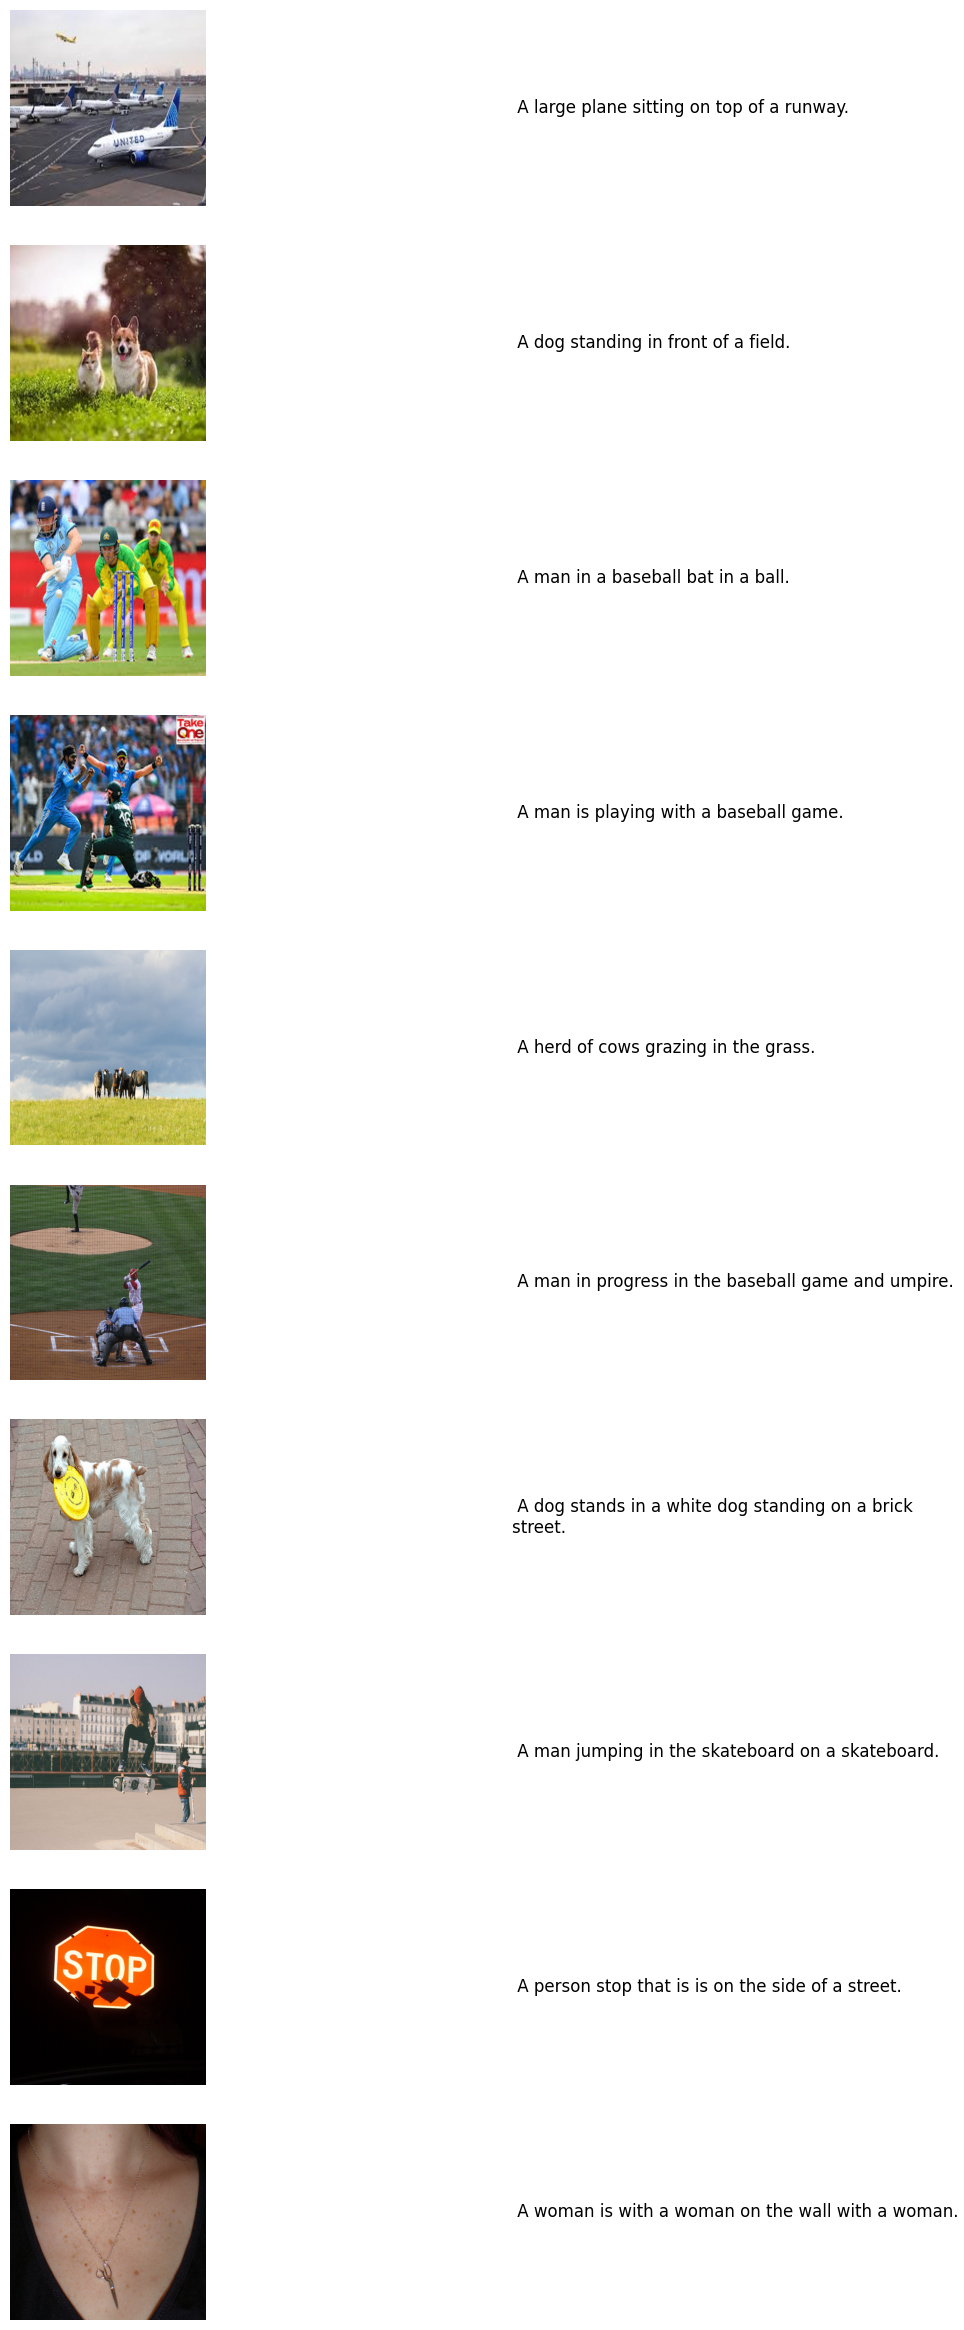

In [10]:
from dataset import load_image, SIZE
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def display_images_with_captions(image_paths, predictions, image_width=10, text_width=4):
    # Ensure we do not exceed the available images or predictions
    num_images = len(image_paths)

    # Dynamically adjust figure height based on the number of images
    fig_height = num_images * 3  # Scale height based on number of images
    fig = plt.figure(figsize=(image_width + text_width, fig_height))
    
    # Create a grid layout with minimal horizontal space
    grid = gridspec.GridSpec(num_images, 2, width_ratios=[image_width, text_width], wspace=0.05)

    for i in range(num_images):
        # Image subplot
        ax_image = plt.subplot(grid[i, 0])
        image = load_image(image_paths[i], size=dataset_config.get('image_size', SIZE), imagenet_normalize=False)
        ax_image.imshow(image)
        ax_image.axis("off")  # Hide axes for images

        # Text subplot
        ax_text = plt.subplot(grid[i, 1])
        ax_text.text(
            0, 0.5, predictions[i], fontsize=12, va='center', ha='left', wrap=True
        )
        ax_text.axis("off")  # Hide axes for text

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage
display_images_with_captions(image_paths, captions)